In [1]:
# model implementation
from ml.models.clustering import KNN
from ml.functions.distance import EuclideanDistance, MahalanobisDistance

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.classification import F1Score, BinaryAccuracy
from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

np.random.seed(25)

## Load dataset

In [2]:
X, y = load_csv('./datasets/kc2.csv')

y = y.astype(int).squeeze()
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

## Q1 a,b - K-Nearest Neighbors (KNN)

### Grid search with cross validation and k-fold(k=10) for KNN(k=1,5) with Euclidean and Mahalanobis distances

In [3]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for k in [1, 5]:
    grid.add(KNN, {"k": k, "distance": EuclideanDistance, "data_scaler": MinMaxScaler})
    grid.add(KNN, {"k": k, "distance": MahalanobisDistance, "data_scaler": MinMaxScaler})

grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)
print("Best KNN:", grid.best_model_params)

Best KNN: {'k': 5, 'distance': <class 'ml.functions.distance.EuclideanDistance'>, 'data_scaler': <class 'ml.algorithms.normalization.MinMaxScaler'>}


### Performance of the best model on the test dataset

In [4]:
knnX = grid.best_model(**grid.best_model_params)
knnX.fit(X_train, y_train)

y_pred = knnX.predict(X_test)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 0.8285714285714286
F1-score: 0.5263157894736842


### Compare to SK-learn's implementation with similar parameters

In [5]:
knn5_sk = KNeighborsClassifier(n_neighbors=5, p=2, algorithm='brute')
knn5_sk.fit(X_train, y_train)

y_pred_sk = knn5_sk.predict(X_test)

print("SK-Learn's KNN5 Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 Accuracy: 0.819047619047619
SK-Learn's KNN5 F1-score: 0.5128205128205129


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	K=1, Euclid.: 0.42835952283011103 +- 0.16989480080646485
	K=1, Mahal.: 0.4643486380059271 +- 0.22021558919452977
	K=5 Euclid.: 0.5159819966456121 +- 0.19132155021570116
	K=5 Mahal.: 0.3675985564143459 +- 0.26336429513052106
RECALL
	K=1, Euclid.: 0.4712121212121212 +- 0.19717471847359724
	K=1, Mahal.: 0.41037878787878784 +- 0.21275555853126474
	K=5 Euclid.: 0.47780303030303034 +- 0.18733917191866167
	K=5 Mahal.: 0.2837878787878788 +- 0.22007078959604148
PRECISION
	K=1, Euclid.: 0.4148068598068598 +- 0.18443823102380463
	K=1, Mahal.: 0.5721753246753247 +- 0.27575886039681197
	K=5 Euclid.: 0.5845346320346321 +- 0.22255964715437884
	K=5 Mahal.: 0.5645238095238095 +- 0.3847702291650183
BINARY_ACCURACY
	K=1, Euclid.: 0.7628339140534262 +- 0.04338814721892593
	K=1, Mahal.: 0.8252032520325203 +- 0.06649790259082448
	K=5 Euclid.: 0.8421602787456447 +- 0.04832470548938935
	K=5 Mahal.: 0.8325783972125436 +- 0.057764020679733234


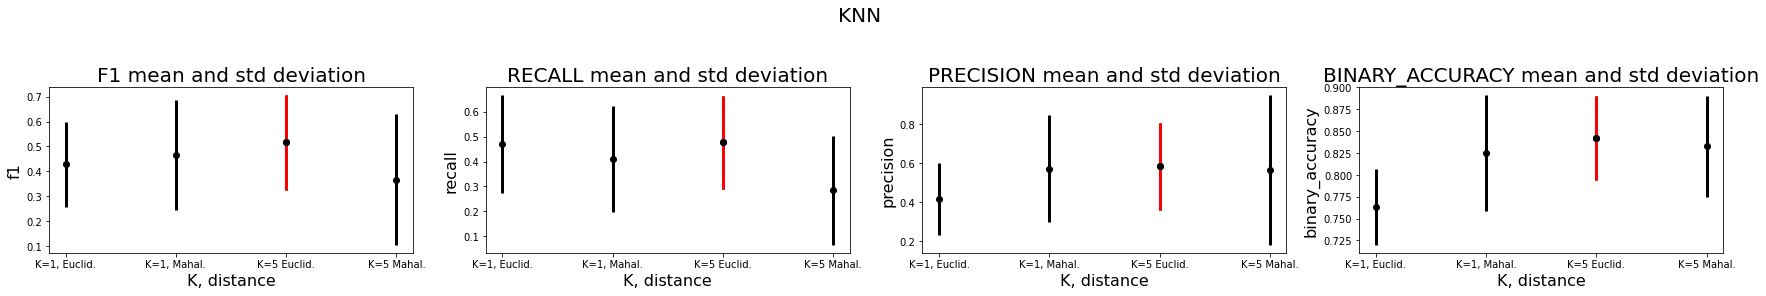

In [6]:
candidates = ["K=1, Euclid.", "K=1, Mahal.", "K=5 Euclid.", "K=5 Mahal."]
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("KNN", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=candidates)
    plt.xlabel("K, distance", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])
    
    k+=1